In [2]:
import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../networks/')

import sqlite3
import pandas as pd
pd.options.mode.chained_assignment = None

import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph_leiden
from functions.datamodel import OptimumParameter
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats

#from region_filters import columns_eu_unique, columns_non_eu_unique
from optimal_clustering import optimal_clustering

pd.options.mode.chained_assignment = None

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

import warnings
# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from functions.env import DB_SCIENCE_PATH_NEW

In [3]:
# 1-get the jaccard similarity between all the differnet regions and a sampling of the regions of the same size

In [4]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [5]:
"""matrix_baseline = pd.read_csv('../networks/matrix/weighted_optimized_before_1700.csv', index_col = [0])
matrix_baseline= pd.read_csv('../networks/matrix/weighted_non_normalized.csv', index_col = [0])
matrix_baseline = matrix_baseline[['source', 'target', 'weight']]
matrix_baseline['weight'] = (matrix_baseline['weight'] - matrix_baseline['weight'].min()) / (matrix_baseline['weight'].max() - matrix_baseline['weight'].min())"""

"matrix_baseline = pd.read_csv('../networks/matrix/weighted_optimized_before_1700.csv', index_col = [0])\nmatrix_baseline= pd.read_csv('../networks/matrix/weighted_non_normalized.csv', index_col = [0])\nmatrix_baseline = matrix_baseline[['source', 'target', 'weight']]\nmatrix_baseline['weight'] = (matrix_baseline['weight'] - matrix_baseline['weight'].min()) / (matrix_baseline['weight'].max() - matrix_baseline['weight'].min())"

In [6]:
import numpy as np

def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    # Add the row[i]/col[i] when there is not information
    all_occupations = list(matrix1.index)

    # Add missing occupations
    for occupation in all_occupations:
        if occupation not in matrix1.columns:
            matrix1[occupation] = 0.0  # Add new column with zeros

    # Resetting the diagonal values to 0 for existing occupations (if necessary)
    for occupation in matrix1.columns:
        matrix1.at[occupation, occupation] = 0.0

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

        # Add the row[i]/col[i] when there is not information
    all_occupations = list(matrix2.index)

    # Add missing occupations
    for occupation in all_occupations:
        if occupation not in matrix2.columns:
            matrix2[occupation] = 0.0  # Add new column with zeros

    # Resetting the diagonal values to 0 for existing occupations (if necessary)
    for occupation in matrix2.columns:
        matrix2.at[occupation, occupation] = 0.0

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2


def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity

In [7]:
dataset_average =  pd.read_csv('edges_list_filtered/average_edges_list.csv', index_col = [0])
df_edges_regions = pd.read_csv('../networks/data/global_before_1700.csv', index_col = [0])
df_edges_regions['meta_occupation']=df_edges_regions['meta_occupation'].apply(lambda x : x.split(' | '))
df_edges_regions = df_edges_regions.explode('meta_occupation')
df_edges_regions = df_edges_regions.reset_index(drop=True)

# # Remove those for original graph with original datasets
# bigger_regions = {'Central Europe':'Eastern Europe', 
#                   'Slav world':'Eastern Europe',
#                   'Balkans':'Eastern Europe',
#                   'Korea':'Asia',
#                   'Chinese world':'Asia', 
#                   'Japan':'Asia', 
#                   'Indian world':'Asia',
#                   'South East Asia':'Asia', 
#                   'Greek World':'Ancient Mediterranean', 
#                   'Latin World':'Ancient Mediterranean',
#                   'Arabic world':'MENA',
#                   'Persian world':'MENA',
#                   'Ottoman Turkey':'MENA',
#                   'Spain':'Iberian Peninsula',
#                   'Portugal':'Iberian Peninsula'}

# df_edges_regions['region_name'] = df_edges_regions['region_name'].apply(lambda x: bigger_regions.get(x, x))
set(df_edges_regions.region_name)



{'Arabic world',
 'Balkans',
 'British Islands',
 'Central Europe',
 'Chinese world',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Korea',
 'Latin World',
 'Low countries',
 'Nordic countries',
 'Ottoman Turkey',
 'Persian world',
 'Portugal',
 'Slav world',
 'South East Asia',
 'Spain'}

In [8]:
# remove regions with less that 10 individuals with at least two occupations

min_individuals = 10

region_counts = df_edges_regions.groupby(['region_name', 'wikidata_id']).agg({'meta_occupation': 'nunique'})
region_counts = region_counts[region_counts['meta_occupation']>1].reset_index()
region_counts = region_counts['region_name'].value_counts()
region_counts = region_counts[region_counts>10]
filtered_regions = list(region_counts.index)

df_edges_regions = df_edges_regions[df_edges_regions['region_name'].isin(filtered_regions)]
df_edges_regions = df_edges_regions.drop_duplicates()

In [9]:
regions_edge_list = {}
final_list = []
for region in df_edges_regions.region_name.unique():

    df_sample = df_edges_regions[df_edges_regions['region_name']==region]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()

    count_duplicates = df_sample.groupby('wikidata_id')['meta_occupation'].nunique()
    len_individuals = (count_duplicates >= 2).sum() # count indivuals with at least tow occupations
    
    #len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    df_net = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()
    regions_edge_list[region] = df_edge_filter # to compute the pairwise distance between regions
    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())


    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})

final_df = pd.DataFrame(final_list)
final_df = final_df.sort_values('score', ascending=False)

    

## Make a random score

In [10]:
def draw_n_occupations(occupations_list, n):
    # Ensure n is not greater than the length of occupations_list
    n = min(n, len(occupations_list))
    
    # Randomly sample n distinct occupations
    sampled_occupations = random.sample(occupations_list, n)
    
    return sampled_occupations

from tqdm import tqdm
occupations_list = list(df_edges_regions['meta_occupation'].unique())
df_cp_occupations = df_edges_regions[['wikidata_id', 'meta_occupation']].drop_duplicates()


final_list = []
for cp_id in tqdm(df_cp_occupations.wikidata_id.unique()):
    df_cp = df_cp_occupations[df_cp_occupations['wikidata_id']==cp_id]

    occupations = list(df_cp['meta_occupation'])
    new_occupations = draw_n_occupations(occupations_list, len(occupations))
    df_cp['meta_occupation'] = new_occupations
    df_cp = df_cp.explode('meta_occupation')
    final_list.append(df_cp)

df_final_random = pd.concat([x for x in final_list])
df_final_random = df_final_random.reset_index(drop=True)

100%|██████████| 13334/13334 [00:16<00:00, 794.94it/s]


In [11]:
df_edges_random = df_edges_regions.copy()
df_edges_random = df_edges_random.drop('meta_occupation', axis=1).drop_duplicates()
df_edges_random = pd.merge(df_edges_random, df_final_random, on = 'wikidata_id')

In [12]:
df_edges_regions.region_name.value_counts()

German world        4422
Italy               2227
France              2158
British Islands     1273
Greek World         1186
Low countries       1112
Central Europe       992
Arabic world         740
Spain                694
Nordic countries     539
Latin World          530
Chinese world        502
Persian world        289
Slav world           236
Indian world         153
Portugal             137
Balkans              118
Name: region_name, dtype: int64

In [13]:
regions_edge_list_random = {}
final_list_random = []
for region in df_edges_random.region_name.unique():

    df_sample = df_edges_random[df_edges_random['region_name']==region]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()

    count_duplicates = df_sample.groupby('wikidata_id')['meta_occupation'].nunique()
    len_individuals = (count_duplicates >= 2).sum() # count indivuals with at least tow occupations
    
    #len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    df_net = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()
    regions_edge_list_random[region] = df_edge_filter # to compute the pairwise distance between regions
    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())


    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list_random.append({'sample_length':len_individuals, 'score':score, 'region':region})

final_df_random = pd.DataFrame(final_list_random)
final_df_random = final_df_random.sort_values('score', ascending=False)
final_df_random = final_df_random.rename(columns={'score':'random_score'})

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in tqdm(regions_edge_list.items()):
    for dataset2_name, dataset2 in regions_edge_list.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
        dataset2 = dataset2[['source', 'target', 'weight']]
        dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
matrix_df = matrix_df.astype(float)


100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


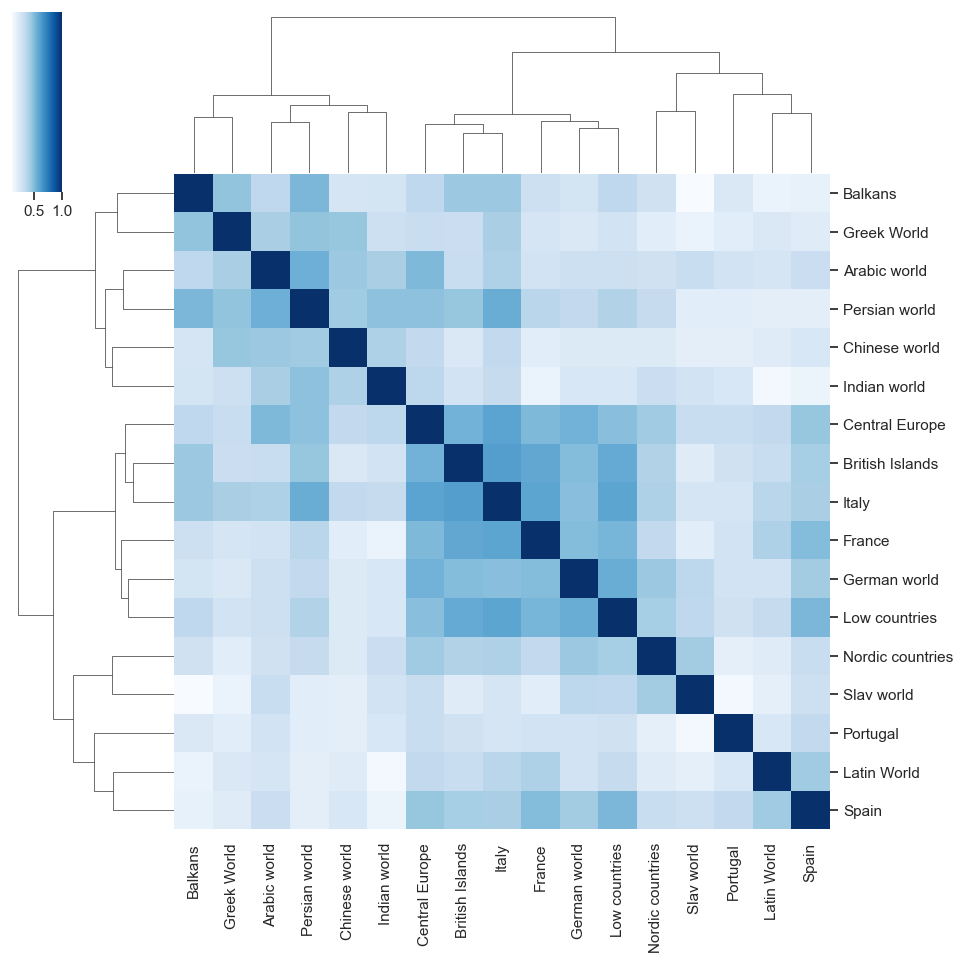

In [15]:
# Create a hierarchical clustered heatmap using seaborn.clustermap
sns.set(font_scale=1.0)
clustered_heatmap = sns.clustermap(
    matrix_df,
    cmap='Blues',
    annot=False,
    fmt=".2f",
    cbar_kws={"orientation": "horizontal", "label": None},  # Hide the color bar (legend)
    method='ward'
)
clustered_heatmap.ax_heatmap.set_ylabel('')  # Set y-label to an empty string
clustered_heatmap.ax_heatmap.set_xlabel('')  # Set y-label to an empty string
clustered_heatmap.cax.set_visible(True)

# Customize the appearance of the clustermap
plt.title('')

# Show the plot
plt.show()

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


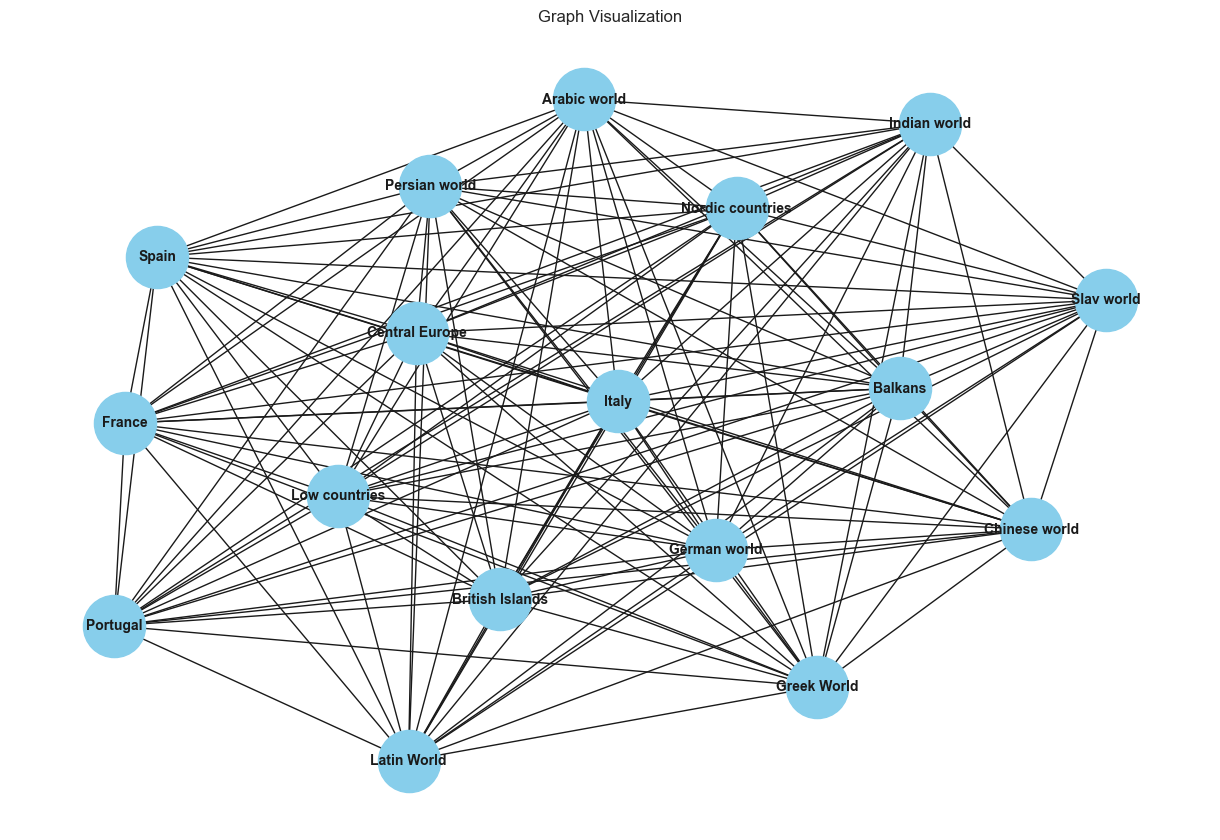

In [16]:
import networkx as nx


df_graph = matrix_df.unstack().reset_index()
df_graph.columns = ['source','target','weight']
df_graph = df_graph[df_graph['source']!=df_graph['target']]

# Create a directed graph
G = nx.from_pandas_edgelist(df_graph, 'source', 'target', ['weight'])
# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)

plt.title("Graph Visualization")
plt.show()

In [17]:
""""min_individuals = 0

final_list = []
for region in list(set(df_regions['region_name'])):
    print(region)
#for region in ['Japan']:

    df_sample = df_regions[df_regions['region_name']==region]


    # count number of individuals with at least two occupations
    count_duplicate = df_sample[df_sample['region_code']==region]
    duplicate_counts = count_duplicate['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(region)

    if duplicate_counts <min_individuals:
        continue
        
 

    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    if len(set(df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())

    matrix1, matrix2 = prepare_edge_list(df_edge, matrix_baseline)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})

final_df = pd.DataFrame(final_list)
final_df = final_df.sort_values('score', ascending=False)"""

'"min_individuals = 0\n\nfinal_list = []\nfor region in list(set(df_regions[\'region_name\'])):\n    print(region)\n#for region in [\'Japan\']:\n\n    df_sample = df_regions[df_regions[\'region_name\']==region]\n\n\n    # count number of individuals with at least two occupations\n    count_duplicate = df_sample[df_sample[\'region_code\']==region]\n    duplicate_counts = count_duplicate[\'wikidata_id\'].value_counts()\n    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])\n\n    print(region)\n\n    if duplicate_counts <min_individuals:\n        continue\n        \n \n\n    df_sample = df_sample[[\'wikidata_id\', \'meta_occupation\']].copy()\n    len_individuals = len(set(df_sample[\'wikidata_id\']))\n    df_sample.columns = ["source", "target"]\n    df_sample["weight"] = 1\n\n    # Draw the graph\n    df_sample = pl.from_pandas(df_sample)\n    df_edge, df_nodes = get_edge_node_table(df_sample)\n\n    if len(set(df_edge[\'weight\']))!=1:\n        df_edge[\'weight\'] = (df_e

Display the distance, add a regresion line and add labels

## plot with labels

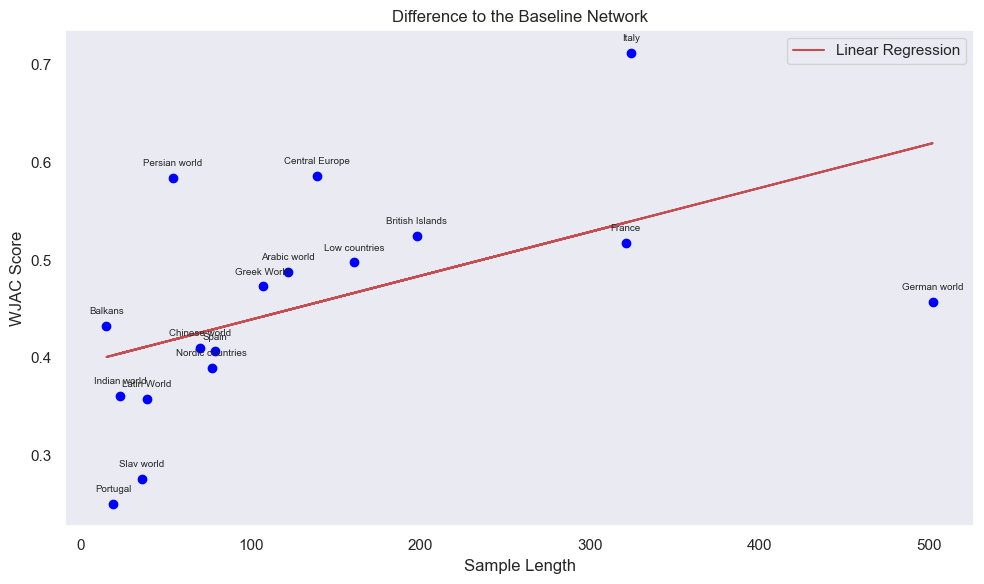

In [18]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

df = final_df.copy()
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['sample_length'], df['score'], color='blue')

for i, row in df.iterrows():
    ax.text(row['sample_length'], row['score']+0.01, row['region'], 
            fontsize=7, ha='center', va='bottom')

X = df[['sample_length']]
y = df['score']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
p_value = model.pvalues[1]
y_pred = model.predict(X)

ax.plot(X['sample_length'], y_pred, color='r', label='Linear Regression')

ax.legend()
ax.set_xlabel('Sample Length')
ax.set_ylabel('WJAC Score')
ax.set_title('Difference to the Baseline Network')
ax.grid(False)

fig.tight_layout()
plt.show()

In [19]:
import numpy as np
import pandas as pd
import random
from scipy.stats import sem, t


def get_wjac_score_from_edge_list(df_sample, dataset_average):

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

    """if len(set(df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())"""

    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())

    return score

In [20]:
count_ind = df_edges_regions.groupby('wikidata_id')['meta_occupation'].nunique()
count_ind = (count_ind >= 2)
list_individuals = list(count_ind.index)
final_list = []
keep_track={}
for region in tqdm(list(set(df_edges_regions['region_name']))):

    df_region_filter = df_edges_regions[df_edges_regions['region_name']==region]

    count_duplicates = df_region_filter.groupby('wikidata_id')['meta_occupation'].nunique()
    count_at_least_two = (count_duplicates >= 2).sum() # count indivuals with at least tow occupations
    len_ind_region = count_at_least_two

    #len_ind_region = len(set(df_region_filter['wikidata_id']))

    scores = []
    for _ in range(20): 
        random.seed() 
        list_individuals_sample = random.sample(list_individuals, len_ind_region)
        df_sample = df_edges_regions[df_edges_regions['wikidata_id'].isin(list_individuals_sample)]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]
        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1

        score = get_wjac_score_from_edge_list(df_sample, dataset_average)
        scores.append(score)
    
    keep_track[region] = scores
    median_score = np.mean(scores)
    ci = t.interval(0.95, len(scores) - 1, loc=np.mean(scores), scale=sem(scores))
    final_list.append({'sample_length':len_ind_region, 'lower_bound':ci[0], 'mean_score':median_score,'upper_bound':ci[1], 'region':region})



  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


In [21]:
final_df_sample = pd.DataFrame(final_list)
final_df_sample = final_df_sample.fillna(0)
final_df_sample = pd.merge(final_df_sample, df, on = ['sample_length', 'region'])
final_df_sample = pd.merge(final_df_sample, final_df_random, on = ['sample_length', 'region'])

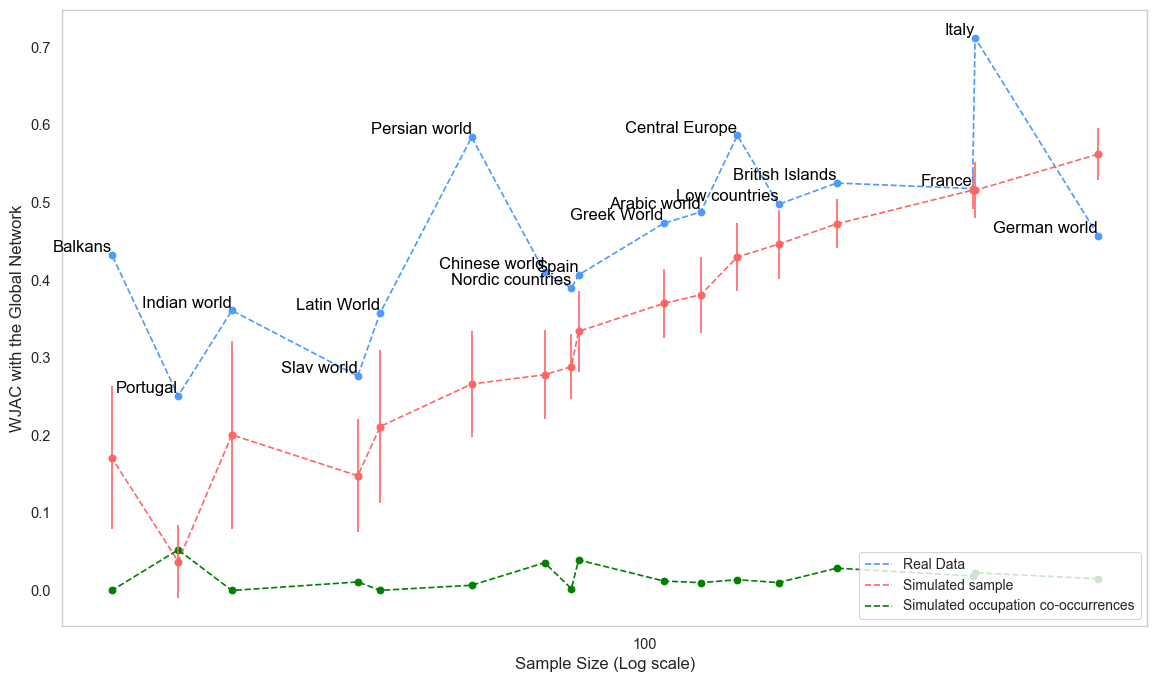

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.style as style
import seaborn


num_regions = len(final_df_sample['region'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, num_regions))


sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red
dark_green = (0.0, 0.5, 0.0)  # Dark green



plt.figure(figsize=(14, 8))

# for i, row in final_df_sample.iterrows():
#     plt.errorbar(row['sample_length'], row['mean_score'], yerr=[[row['mean_score'] - row['lower_bound']], [row['upper_bound'] - row['mean_score']]], fmt='o', color=colors[i])
#     plt.text(final_df_sample['sample_length'][i], final_df_sample['score'][i], final_df_sample['region'][i],  color=colors[i], fontsize=12, ha='right', va='bottom')
#     plt.scatter(row['sample_length'], row['score'], color=colors[i])


for i, row in final_df_sample.iterrows():
    plt.text(final_df_sample['sample_length'][i], final_df_sample['score'][i], final_df_sample['region'][i],  fontsize=12, ha='right', va='bottom', color = 'black')
    plt.errorbar(row['sample_length'], row['mean_score'], yerr=[[row['mean_score'] - row['lower_bound']], [row['upper_bound'] - row['mean_score']]], fmt='o', color = light_red)
    plt.scatter(row['sample_length'], row['score'], color = light_blue)
    plt.scatter(row['sample_length'], row['random_score'], color = dark_green)



# # Calculate linear regression line
# x = np.log(final_df_sample['sample_length'])
# y = final_df_sample['mean_score']
# coefficients = np.polyfit(x, y, 1)
# poly = np.poly1d(coefficients)

# plt.plot(np.exp(x), poly(x), color="black", linestyle='--', label='Linear Regression')
    
final_df_sample = final_df_sample.sort_values('sample_length', ascending=False)
plt.plot(final_df_sample['sample_length'], final_df_sample['score'], color=light_blue, linestyle='--', label='Real Data')
plt.plot(final_df_sample['sample_length'], final_df_sample['mean_score'], color=light_red, linestyle='--', label='Simulated sample')
plt.plot(final_df_sample['sample_length'], final_df_sample['random_score'], color=dark_green, linestyle='--', label='Simulated occupation co-occurrences')


plt.xlabel('Sample Size (Log scale)', fontsize=12)
plt.ylabel('WJAC with the Global Network', fontsize=12)
plt.title('', fontsize=14)
plt.grid(False)
plt.legend(loc='lower right', fontsize=10)  # Add legend for linear regression line

plt.xscale('log')  # Set x-axis scale to logarithmic
plt.gca().xaxis.set_major_formatter(ScalarFormatter())



In [23]:
from scipy.stats import ttest_rel
import numpy as np

# Perform the T-Test
t_statistic, p_value = ttest_rel(final_df_sample['mean_score'], final_df_sample['score'])

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

mean_score_std = np.mean(final_df_sample['mean_score'])
score_std = np.mean(final_df_sample['score'])
print(np.std(final_df_sample['mean_score']))
np.std(final_df_sample['score'])

T-Statistic: -5.182455769849453
P-Value: 9.075100717276747e-05
0.14437997121063553


0.11196970135790994

In [24]:
final_df_sample[['mean_score', 'score']].corr(method='pearson')

,mean_score,score
mean_score,1.000000,0.751703
score,0.751703,1.000000


In [25]:
# random times

## Random time

In [26]:
df_time = df_edges_regions.copy()
df_time['time'] = df_time['birthyear'].apply(lambda year: round(year, -2))
df_time = df_time[['wikidata_id', 'meta_occupation', 'time']].copy()

In [27]:
df_edges_random['time'] =  df_edges_random['birthyear'].apply(lambda year: round(year, -2))

In [28]:
time_edge_list_random = {}
final_list_random = []
for time in df_edges_random.time.unique():

    df_sample = df_edges_random[df_edges_random['time']==time]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()

    count_duplicates = df_sample.groupby('wikidata_id')['meta_occupation'].nunique()
    len_individuals = (count_duplicates >= 2).sum() # count indivuals with at least tow occupations
    
    #len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    df_net = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()
    regions_edge_list_random[region] = df_edge_filter # to compute the pairwise distance between regions
    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())


    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list_random.append({'sample_length':len_individuals, 'score':score, 'time':time})

final_df_random_time = pd.DataFrame(final_list_random)
final_df_random_time = final_df_random_time.sort_values('score', ascending=False)
final_df_random_time = final_df_random_time.rename(columns={'score':'random_score'})

In [29]:

final_list = []
#for time in [600]:
for time in tqdm(sorted(list(set(df_time.time)))):
    df_time_filter = df_time[df_time['time']==time]
    count_duplicates = df_time_filter.groupby('wikidata_id')['meta_occupation'].nunique()
    len_ind_time = (count_duplicates >= 2).sum() # count indivuals with at least tow occupations

    df_time_real = df_time_filter[['wikidata_id', 'meta_occupation']].copy()
    df_time_real.columns = ["source", "target"]
    df_time_real["weight"] = 1
    real_score = get_wjac_score_from_edge_list(df_time_real, dataset_average)
    
    scores = []
    for _ in range(20): 
        random.seed() 
        list_individuals_sample = random.sample(list_individuals, len_ind_time)
        df_sample = df_time[df_time['wikidata_id'].isin(list_individuals_sample)]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]
        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1
        score = get_wjac_score_from_edge_list(df_sample, dataset_average)
        scores.append(score)

    median_score = np.mean(scores)
    ci = t.interval(0.95, len(scores) - 1, loc=np.mean(scores), scale=sem(scores))

    final_list.append({'sample_length':len_ind_time, 'lower_bound':ci[0], 'mean_score':median_score,'upper_bound':ci[1], 'time':time, 'score':real_score})

final_df_time = pd.DataFrame(final_list)
final_df_time = final_df_time.sort_values('time')
final_df_time = final_df_time.dropna()
final_df_time = pd.merge(final_df_random_time, final_df_time, on = ['sample_length', 'time'])

  0%|          | 0/26 [00:00<?, ?it/s]/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
  4%|▍         | 1/26 [00:01<00:26,  1.07s/it]/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2

In [30]:
final_df_time

,sample_length,random_score,time,lower_bound,mean_score,upper_bound,score
0,17,0.040608,100.0,0.005737,0.060568,0.115399,0.491875
1,432,0.033466,1500.0,0.545958,0.579743,0.613527,0.623313
2,487,0.020838,1700.0,0.526274,0.556414,0.586555,0.532560
3,754,0.018257,1600.0,0.579385,0.603725,0.628065,0.641007
4,111,0.006036,1400.0,0.333836,0.388830,0.443823,0.561508
5,40,0.002460,800.0,0.161789,0.236096,0.310403,0.585898
6,9,0.001374,-600.0,-0.016145,0.014771,0.045688,0.383714
7,77,0.001220,1200.0,0.260843,0.319350,0.377857,0.410984
8,44,0.000829,1000.0,0.119423,0.195508,0.271593,0.485987
9,62,0.000533,1100.0,0.264184,0.320176,0.376168,0.473455


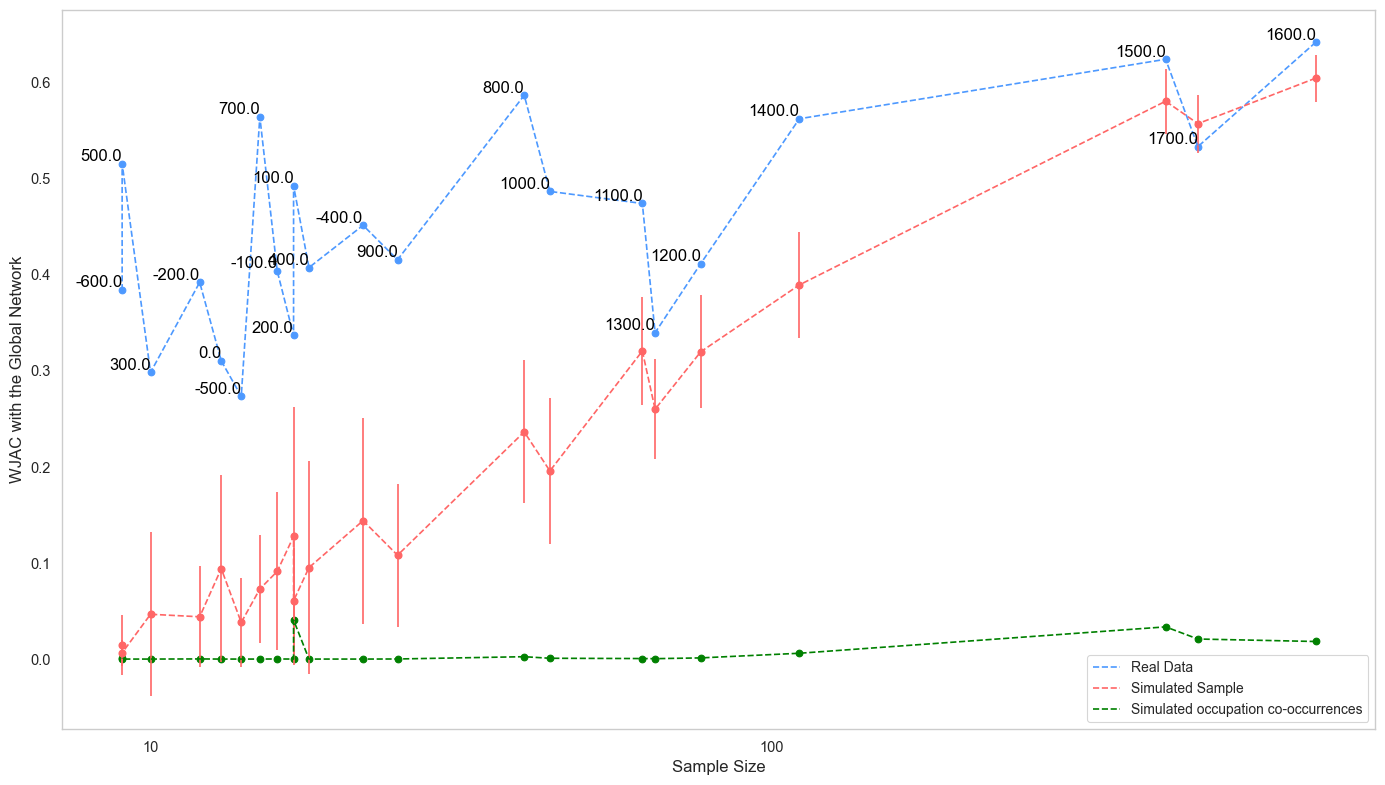

In [31]:
# Define the number of colors
num_colors = 25

# Create a colormap
cmap = plt.cm.viridis

num_times= len(final_df_time['time'].unique())
colors_time = plt.cm.viridis(np.linspace(0, 1, num_times))


first_row = colors_time[0]
num_new_rows = 3
num_columns = colors_time.shape[1]
random_colors = np.random.rand(num_new_rows, num_columns)
colors_time = np.vstack([colors_time, random_colors])

# plt.figure(figsize=(14, 8))
# for i, row in final_df_time.iterrows():
# #for i in range(len(final_df_sample['sample_length'])):
#     plt.errorbar(row['sample_length'], row['mean_score'], yerr=[[row['mean_score'] - row['lower_bound']], [row['upper_bound'] - row['mean_score']]], fmt='o', color = colors_time[i])
#     plt.text(final_df_time['sample_length'][i], final_df_time['score'][i], final_df_time['time'][i], fontsize=10, ha='right', va='bottom', color = colors_time[i])
#     plt.scatter(row['sample_length'], row['score'], color = colors_time[i])

plt.figure(figsize=(14, 8))
for i, row in final_df_time.iterrows():
#for i in range(len(final_df_sample['sample_length'])):
    plt.errorbar(row['sample_length'], row['mean_score'], yerr=[[row['mean_score'] - row['lower_bound']], [row['upper_bound'] - row['mean_score']]], fmt='o', color = light_red)
    plt.text(final_df_time['sample_length'][i], final_df_time['score'][i], final_df_time['time'][i], fontsize=12, ha='right', va='bottom', color = 'black')
    plt.scatter(row['sample_length'], row['score'],  color = light_blue)
    plt.scatter(row['sample_length'], row['random_score'],  color = dark_green)


# # Calculate linear regression line
# x = np.log(final_df_time['sample_length'])
# y = final_df_time['mean_score']
# coefficients = np.polyfit(x, y, 1)
# poly = np.poly1d(coefficients)
# plt.plot(np.exp(x), poly(x), color=light_red, linestyle='-', label='Linear Regression')
    
final_df_time = final_df_time.sort_values('sample_length', ascending=False)
plt.plot(final_df_time['sample_length'], final_df_time['score'], color=light_blue, linestyle='--', label='Real Data')
plt.plot(final_df_time['sample_length'], final_df_time['mean_score'], color=light_red, linestyle='--', label='Simulated Sample')
plt.plot(final_df_time['sample_length'], final_df_time['random_score'], color=dark_green, linestyle='--', label='Simulated occupation co-occurrences')


plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('WJAC with the Global Network', fontsize=12)
plt.title('', fontsize=14)
plt.grid(False)
plt.xscale('log')  # Set x-axis scale to logarithmic

plt.gca().xaxis.set_major_formatter(ScalarFormatter())

plt.legend(loc='lower right', fontsize=10)  # Add legend for linear regression line

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

In [32]:
# Perform the T-Test
t_statistic, p_value = ttest_rel(final_df_time['mean_score'], final_df_time['score'])

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


score_std = np.mean(final_df_time['score'])
mean_score_std = np.mean(final_df_time['mean_score'])
print(score_std)
print(mean_score_std)

T-Statistic: -8.063816918358055
P-Value: 7.248615844324143e-08
0.44965287659550945
0.20010084488020452


In [33]:
np.std(final_df_time['mean_score'])

0.1828988160425147

In [34]:
np.std(final_df_time['score'])
np.std(final_df_time['mean_score'])

0.1828988160425147

In [35]:
final_df_time[['mean_score', 'score']].corr(method='pearson')

,mean_score,score
mean_score,1.000000,0.634839
score,0.634839,1.000000


In [36]:

final_list = []
list_individuals = list(set(df_edges_regions.wikidata_id))
for region in list(set(df_edges_regions['region_name'])):
    
    df_region_filter = df_edges_regions[df_edges_regions['region_name']==region]
    len_ind_region = len(set(df_region_filter['wikidata_id']))
    

    # count number of individuals with at least two occupations
    count_duplicate = df_region_filter[df_region_filter['region_name']==region]
    duplicate_counts = count_duplicate['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(region, duplicate_counts)

    random.seed(39)
    list_individuals_sample = random.sample(list_individuals, len_ind_region)

    df_sample = df_edges_regions[df_edges_regions['wikidata_id'].isin(list_individuals_sample)]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    len_individuals = len(set(df_sample['wikidata_id']))


    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

    """if len(set(df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())"""
    
    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})

final_df_sample = pd.DataFrame(final_list)
final_df_sample['region'] = final_df_sample['region'] + '_sample'
final_df_sample = final_df_sample.rename(columns = {'score':'score_sample', 'region':'region_sample'})
df_plot = pd.merge(final_df, final_df_sample, on = 'sample_length')


Persian world 54
Latin World 215
Italy 324
Arabic world 122
Central Europe 139
Portugal 19
Balkans 15
Greek World 442
Slav world 36
Indian world 23
Chinese world 70
German world 502
Low countries 161
France 321
Nordic countries 77
British Islands 198
Spain 79


In [37]:
df_plot

,sample_length,score,region,score_sample,region_sample


#### Plot Both

ValueError: zero-size array to reduction operation maximum which has no identity

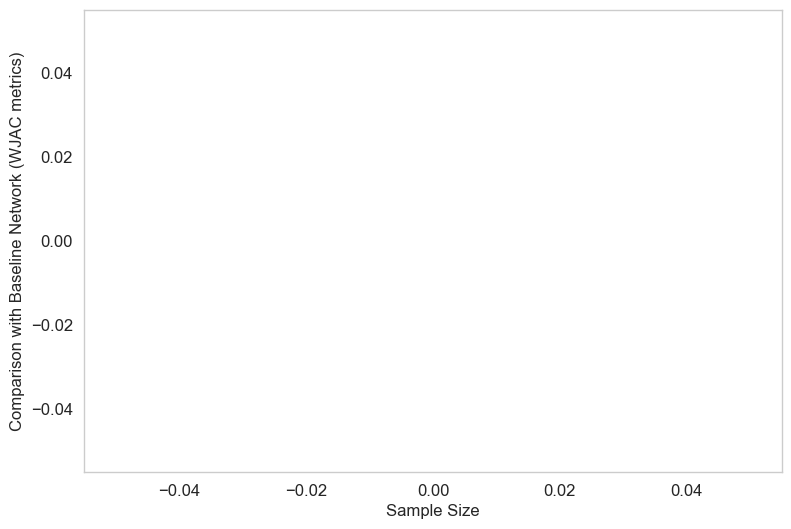

In [38]:
# Separate 'ari' and 'ari_sample' values into two lists
df_plot = df_plot.sort_values('sample_length')
ari_values = df_plot['score']
ari_sample_values = df_plot['score_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05

# Extracting data from the DataFrame
sample_length = df_plot['sample_length']
ari = df_plot['score']
ari_sample = df_plot['score_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['score'], label='score', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)


# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['score_sample'], label='score_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network (WJAC metrics)', fontsize=12)
ax.set_title('', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['sample_length'], df_plot['score'], df_plot['score_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['sample_length'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}*)"])

# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

### Plot the logs

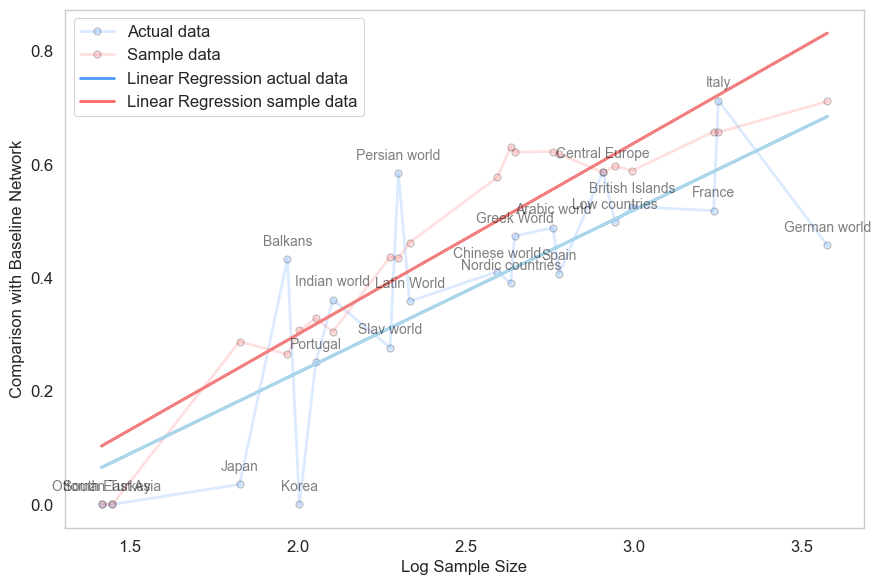

In [ ]:
df_plot[['score', 'score_sample']].corr()

# Extracting data from the DataFrame
sample_length = np.log10(df_plot['sample_length'])
ari = df_plot['score']
ari_sample = df_plot['score_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']
df_plot['log_size'] = np.log10(df_plot['sample_length'])

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['score'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['score_sample'], label='score_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network', fontsize=12)
ax.set_title('', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['log_size'], df_plot['score'], df_plot['score_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')

    
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

# Get coefficients instead of p-values
coeff_1 = round(model.params[1], 3)
coeff_2 = round(model_2.params[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model.predict(X), color='lightblue', label=f'Linear Regression (Coeff: {coeff_1})', linewidth=2)
plt.plot(df_plot['log_size'], model_2.predict(X), color='lightcoral', label=f'Linear Regression (Coeff: {coeff_2})', linewidth=2)


ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                            #f'Linear Regression (Coeff: {coeff_1})',
                                            #f'Linear Regression (Coeff: {coeff_2})'])

plt.tight_layout()
plt.show()


In [ ]:
df_plot[['score', 'score_sample']].corr()

,score,score_sample
score,1.000000,0.798078
score_sample,0.798078,1.000000


### Baseline Century

In [ ]:
df_time = df_edges_regions.copy()
df_time['time'] = df_time['birthyear'].apply(lambda year: round(year, -2))
df_time = df_time[['wikidata_id', 'meta_occupation', 'time']].copy()
df_time

final_list = []
#for time in [600]:
for time in sorted(list(set(df_time.time))):

    df_sample = df_time[df_time['time']==time]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    

    """
     # count number of individuals with at least two occupations
    duplicate_counts = df_sample['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(time, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue
        
    """

    len_individuals = len(set(df_sample['wikidata_id']))
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())


    """if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())
    """
    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'time':time})

final_df_time = pd.DataFrame(final_list)
final_df_time = final_df_time.sort_values('time')
final_df_time['log_size'] = np.log10(final_df_time['sample_length']+1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


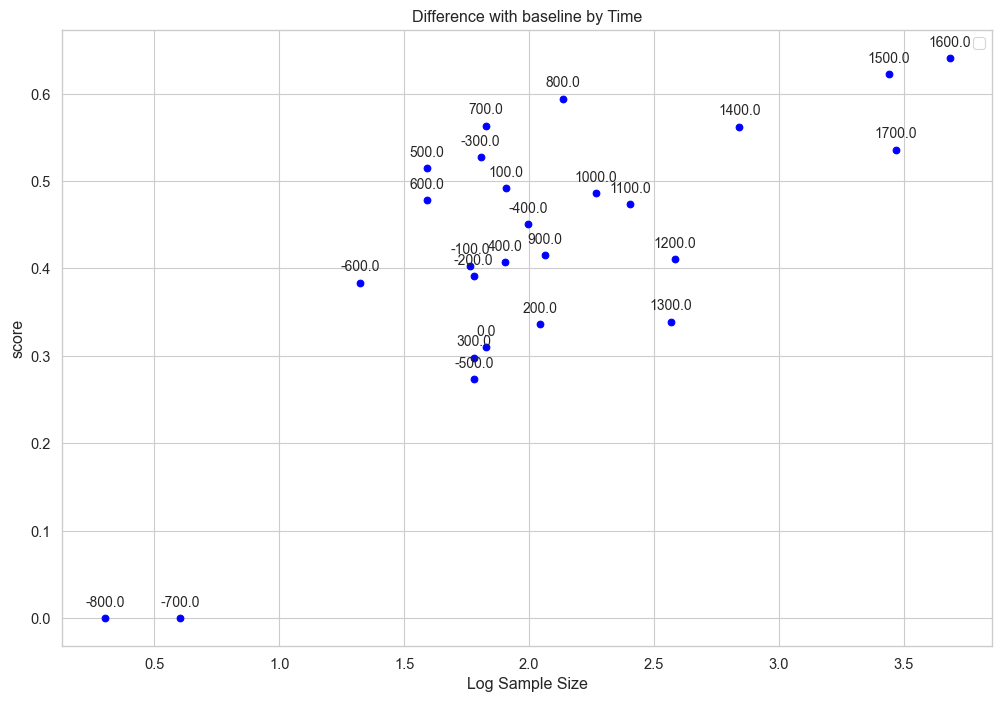

<Figure size 640x480 with 0 Axes>

In [ ]:
sample_lengths = [entry for entry in final_df_time['log_size']]
ari_values = [entry for entry in final_df_time['score']]
times = [entry for entry in final_df_time['time']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, time in enumerate(times):
    plt.text(sample_lengths[i], ari_values[i]+0.01, time, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Log Sample Size')
plt.ylabel('score')
plt.title('Difference with baseline by Time')
plt.grid(True)


plt.legend()
plt.grid(True)
plt.show()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import random

list_individuals = list(set(df_time.wikidata_id))

final_list = []
for time in list(set(df_time['time'])):


    df_time_filter = df_time[df_time['time']==time]
    len_ind_time = len(set(df_time_filter['wikidata_id']))
    
    """
    
        # count number of individuals with at least two occupations
    duplicate_counts = df_time_filter['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(time, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue
        
    """

    random.seed(42)
    list_individuals_sample = random.sample(list_individuals, len_ind_time)
    df_sample = df_time[df_time['wikidata_id'].isin(list_individuals_sample)]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    len_individuals = len(set(df_sample['wikidata_id']))

    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)


    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

    """ if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())
    """
    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'time':time})

final_df_time_sample = pd.DataFrame(final_list)
final_df_time_sample = final_df_time_sample.sort_values('sample_length')

final_df_time_sample = final_df_time_sample.rename(columns = {'score':'score_sample', 'time':'time_sample'})
df_plot_sample = pd.merge(final_df_time_sample, final_df_time, on = ['sample_length'])

df_plot_sample['log_size'] = np.log10(df_plot_sample['sample_length']+1)
df_plot_sample = df_plot_sample[df_plot_sample['sample_length']>10]

Plot the T statistics

In [ ]:

ari_values = df_plot_sample['score']
ari_sample_values = df_plot_sample['score_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05
t_statistic

-0.5702333673767567

In [ ]:
df_plot_sample[['score_sample', 'score']].corr()

,score_sample,score
score_sample,1.000000,0.499215
score,0.499215,1.000000


0.00217
4e-05


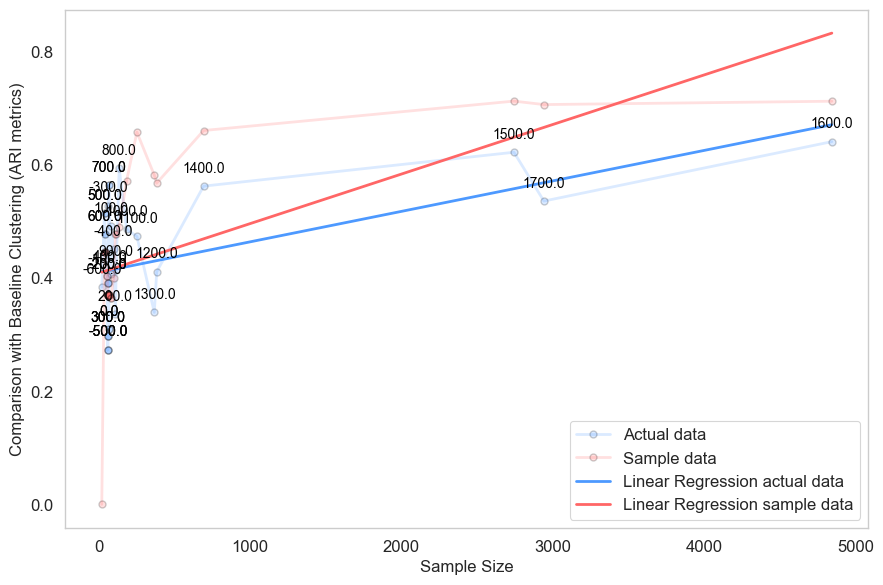

In [ ]:
# Extracting data from the DataFrame
sample_length = df_plot_sample['sample_length']
ari = df_plot_sample['score']
ari_sample = df_plot_sample['score_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['score'], label='score', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['score_sample'], label='score_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)



# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['sample_length'], df_plot_sample['score'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['sample_length']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['sample_length'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])




plt.tight_layout()
# Show the plot
plt.show()

0.00281
0.0


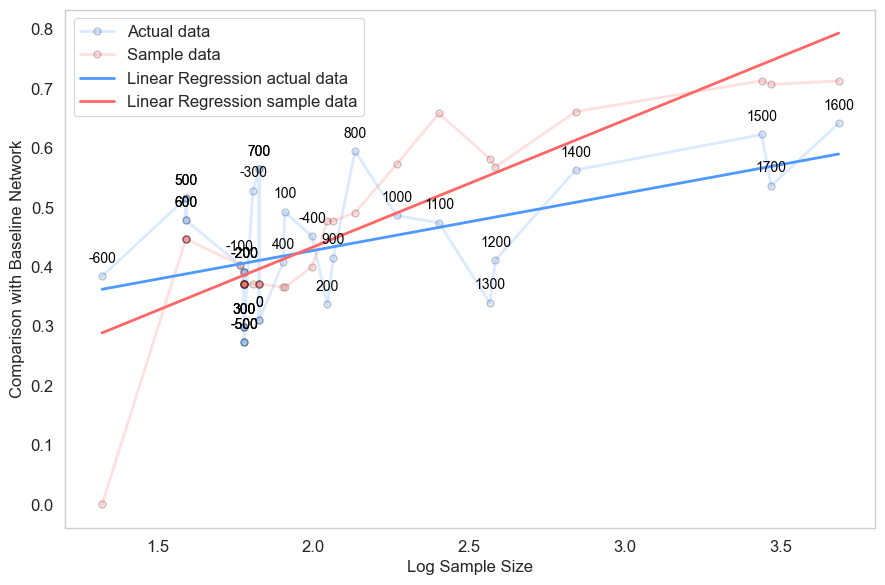

In [ ]:
df_plot_sample['time'] = df_plot_sample['time'].astype(int)

import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for improved style

# Extracting data from the DataFrame
log_size = df_plot_sample['log_size']
ari = df_plot_sample['score']
ari_sample = df_plot_sample['score_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['log_size'], df_plot_sample['score'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['log_size'], df_plot_sample['score_sample'], label='score_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network', fontsize=12)
ax.set_title('', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['log_size'], df_plot_sample['score'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['log_size']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)


model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['log_size'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ]) 
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])


plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

In [ ]:
df_plot_sample[['score_sample','score']].corr()

,score_sample,score
score_sample,1.000000,0.499215
score,0.499215,1.000000
